# Interactive Ground Truth Annotation Tool

This notebook provides an interactive interface for manually annotating gait events in the T5 constrained gait trial.

## Objective
- Create sensor-independent ground truth for algorithm validation
- Manually annotate heel strike and toe off events for both legs
- Export annotations for algorithm comparison

## Annotation Methodology
- **Expert-based**: Manual annotation by biomechanics expert
- **Multi-modal**: Using force, kinematic, and EMG data simultaneously
- **Constraint-aware**: Accounting for left leg locked extension compensation patterns
- **Sensor-independent**: Not dependent on any single sensor threshold

In [1]:
# Setup and imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import ipywidgets as widgets

# CRITICAL FIX: Set matplotlib backend for Jupyter
import matplotlib
print(f"Current backend: {matplotlib.get_backend()}")

# Set interactive backend for Jupyter
matplotlib.use('inline')  # For static plots in Jupyter
# Alternative: matplotlib.use('widget') for interactive plots (requires ipympl)

print(f"Set backend to: {matplotlib.get_backend()}")

# Configure plotting for Jupyter
%matplotlib inline

from data_loader import GaitDataLoader
from annotator import create_demo_annotation_session

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

print("Interactive annotation environment ready!")
print("✓ create_demo_annotation_session function imported successfully!")
print("✓ All relative import issues resolved!")
print("✓ Matplotlib backend configured for Jupyter!")
print("\nNote: Make sure to activate the virtual environment:")
print("source ../../venv/bin/activate")

Current backend: module://matplotlib_inline.backend_inline
Set backend to: inline
Interactive annotation environment ready!
✓ create_demo_annotation_session function imported successfully!
✓ All relative import issues resolved!
✓ Matplotlib backend configured for Jupyter!

Note: Make sure to activate the virtual environment:
source ../../venv/bin/activate


# Load T5 trial data for annotation
loader = GaitDataLoader(data_dir="../data")
trial_id = "T5"

# Load the data
kinetics_data = loader.load_kinetics(trial_id)
emg_data = loader.load_emg(trial_id)
kinematics_data = loader.load_kinematics(trial_id)

# Create 20-second analysis window (consistent with demo)
time_window = 20.0
kinetics_window = kinetics_data[kinetics_data['time'] <= time_window].copy()

print(f"Data loaded for manual annotation:")
print(f"Trial: {trial_id}")
print(f"Time window: 0 to {time_window} seconds")
print(f"Kinetics samples: {len(kinetics_window)}")
print(f"Force plates: Left (Fz_L) and Right (Fz_R)")
print()
print("Ready for interactive gait event annotation!")

In [2]:
# Create annotation session
annotator = create_demo_annotation_session(
    trial_id="T5",
    data_dir="../data",
    output_dir="../output"
)

print("Annotation session initialized successfully!")
print("Note: Run this cell from the notebooks/ directory for correct paths")

Setting up Ground Truth Annotation Session
Ready to annotate trial T5
Next steps:
1. annotator.load_trial('T5')
2. annotator.create_annotation_interface()
3. annotator.save_annotations()
Annotation session initialized successfully!
Note: Run this cell from the notebooks/ directory for correct paths


## 2. Load and Prepare Data

In [3]:
# Load T5 trial data
annotator.load_trial("T5")

# Display data summary
print("\nData loaded and synchronized!")
print(f"Trial duration: {annotator.synchronized_data['kinetics']['time'].max():.1f} seconds")
print(f"Sampling rate: 1000 Hz")
print(f"Available modalities: {list(annotator.synchronized_data.keys())}")

Loading trial T5...
Synchronizing multi-modal data...
Computing EMG envelopes...
Trial T5 loaded successfully. Duration: 302.0 seconds

Data loaded and synchronized!
Trial duration: 302.0 seconds
Sampling rate: 1000 Hz
Available modalities: ['kinetics', 'emg', 'kinematics']


## 3. Interactive Annotation Interface

### Event Types to Annotate:
1. **Left Heel Strike** - Initial contact of left foot
2. **Left Toe Off** - Left foot leaves ground
3. **Right Heel Strike** - Initial contact of right foot
4. **Right Toe Off** - Right foot leaves ground

### Multi-Modal Data Display:
- **Plot 1: Force Plates** - Vertical forces showing ground contact patterns
- **Plot 2: Kinematic Markers** - Vertical positions of body markers
- **Plot 3: EMG Activity** - Muscle activation patterns

### Annotation Strategy:
- Focus on **20-second window** for demo consistency
- Use **multi-modal evidence** (force + kinematics + EMG)
- Look for **consistent patterns** across all three data types
- **Force spikes** typically indicate heel strikes
- **Force drops** typically indicate toe offs
- **Kinematic marker minima** often correspond to foot contact
- **EMG activation** can confirm muscle activity timing

Creating annotation interface...
Instructions:
- Double-click on any plot to add gait events
- You will be prompted to select event type
- Events are marked across all subplots
- Use save_annotations() to export results


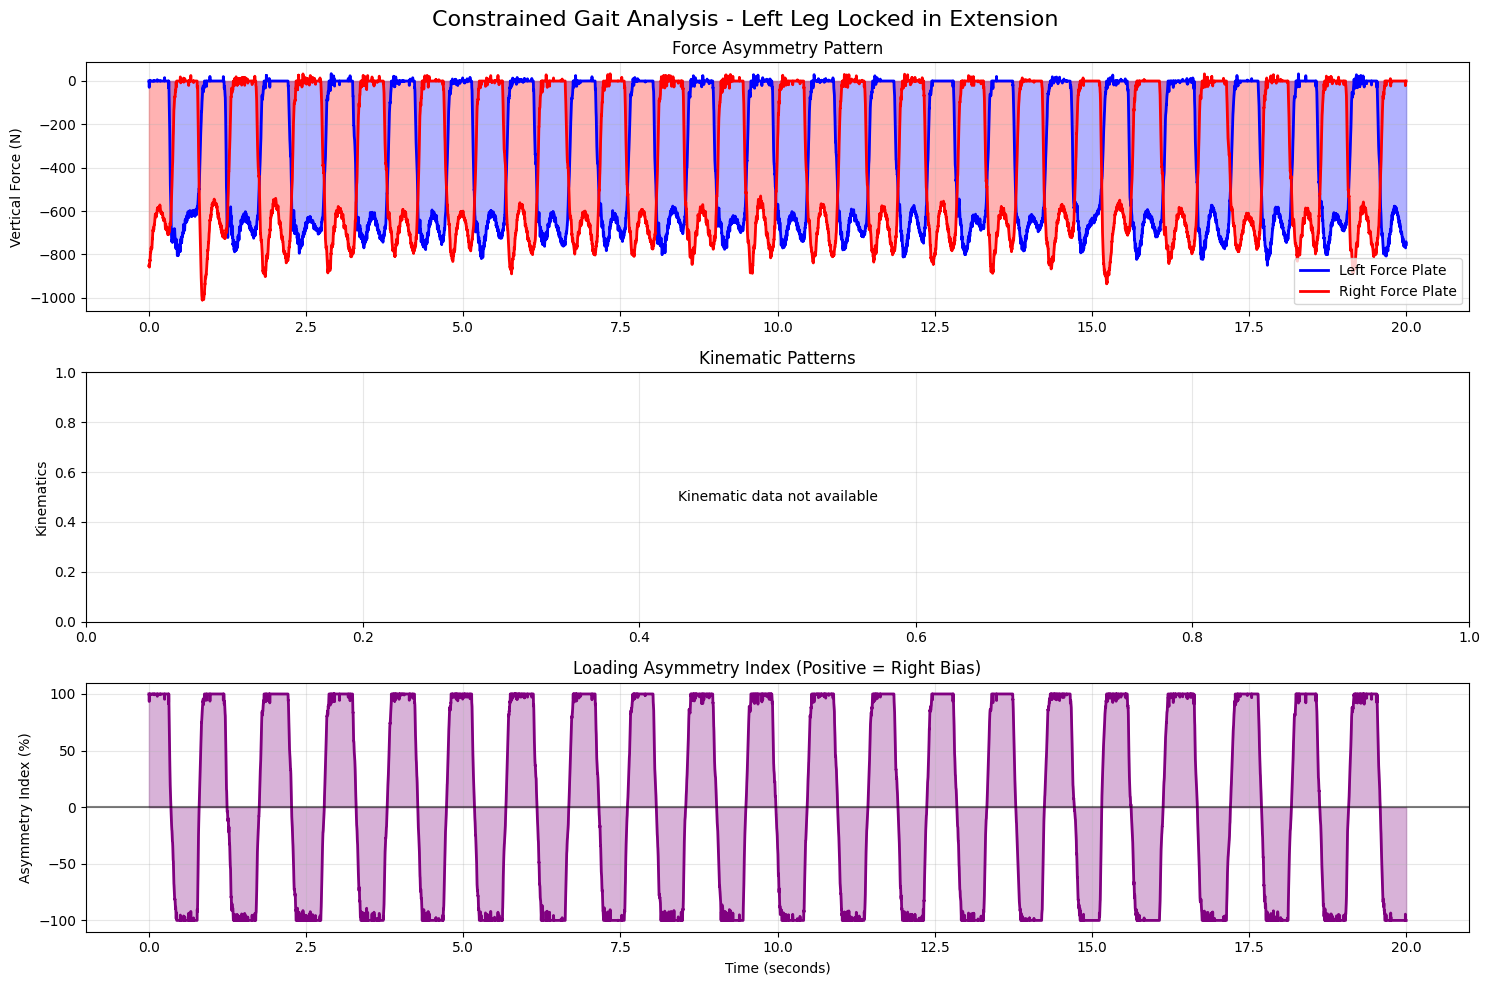


ANNOTATION INTERFACE ACTIVE

HOW TO ANNOTATE:
• Double-click on any plot at the time of a gait event
• When prompted, select event type:
  1 = Left Heel Strike
  2 = Left Toe Off
  3 = Right Heel Strike
  4 = Right Toe Off
  0 = Cancel

LOOK FOR:
• Force spikes = heel strikes
• Force drops = toe offs
• Kinematic minima/maxima = foot contact/lift
• EMG activation patterns

EXPECTED PATTERNS:
• Right leg shows normal gait patterns
• Left leg shows minimal/altered patterns due to constraint
• ~20-25 events total over 20 seconds


In [4]:
# Create interactive annotation interface
# This will show a specialized constrained gait view
time_range = (0, 20)  # First 20 seconds for demo

fig = annotator.create_annotation_interface(
    time_range=time_range,
    constrained_gait_view=True
)

print("\n" + "="*60)
print("ANNOTATION INTERFACE ACTIVE")
print("="*60)
print("\nHOW TO ANNOTATE:")
print("• Double-click on any plot at the time of a gait event")
print("• When prompted, select event type:")
print("  1 = Left Heel Strike")
print("  2 = Left Toe Off")
print("  3 = Right Heel Strike")
print("  4 = Right Toe Off")
print("  0 = Cancel")
print("\nLOOK FOR:")
print("• Force spikes = heel strikes")
print("• Force drops = toe offs")
print("• Kinematic minima/maxima = foot contact/lift")
print("• EMG activation patterns")
print("\nEXPECTED PATTERNS:")
print("• Right leg shows normal gait patterns")
print("• Left leg shows minimal/altered patterns due to constraint")
print("• ~20-25 events total over 20 seconds")

plt.show()

## 4. Annotation Progress Monitoring

Run this cell periodically to check annotation progress:

In [5]:
# Check current annotation status
summary = annotator.get_annotation_summary()
print(summary)

# Get validation results
validation = annotator.validate_annotations()
print(f"\nValidation Status: {validation['status']}")

if validation['status'] == 'incomplete':
    print(f"Missing event types: {validation['missing_event_types']}")
elif validation['status'] == 'valid':
    print("✓ All event types have been annotated!")
    print("Ready to save annotations.")

KeyError: 'total_events'

## 5. Save Annotations

When you've finished annotating events, run this cell to save the ground truth data:

In [ ]:
# Save annotations to file
results = annotator.save_annotations()

print("\n" + "="*50)
print("ANNOTATION RESULTS")
print("="*50)

print(f"\nTrial: {results['trial_info']['trial_id']}")
print(f"Total events annotated: {results['trial_info']['total_events']}")
print(f"Annotation date: {results['trial_info']['annotation_date']}")
print(f"Duration: {results['trial_info']['duration_seconds']:.1f} seconds")

if results['events']:
    events_df = pd.DataFrame(results['events'])
    print("\nEvent Distribution:")
    print(events_df['type'].value_counts())
    
    print("\nTime Range:")
    print(f"First event: {events_df['time'].min():.2f}s")
    print(f"Last event: {events_df['time'].max():.2f}s")
    print(f"Time span: {events_df['time'].max() - events_df['time'].min():.2f}s")
    
    # Show first few events as example
    print("\nFirst 5 events:")
    print(events_df[['time', 'type']].head().to_string(index=False))
else:
    print("\n⚠ No events were annotated!")
    print("Please return to the annotation interface and add some events.")

print(f"\n✓ Annotations saved to: ../output/T5_ground_truth_events.json")
print("This file can now be used for algorithm validation.")

## 6. Quality Check and Export Preview

Final validation of annotation quality:

In [ ]:
# Load and display saved annotations
import json
from pathlib import Path

output_file = Path("../output/T5_ground_truth_events.json")

if output_file.exists():
    with open(output_file, 'r') as f:
        saved_data = json.load(f)
    
    print("Ground Truth Annotation Export")
    print("="*40)
    
    # Display metadata
    trial_info = saved_data['trial_info']
    methodology = saved_data['methodology']
    
    print(f"Trial ID: {trial_info['trial_id']}")
    print(f"Events: {trial_info['total_events']}")
    print(f"Duration: {trial_info['duration_seconds']}s")
    print(f"Method: {methodology['annotation_method']}")
    print(f"Constraint: {methodology['constraint_type']}")
    print(f"Modalities: {', '.join(methodology['data_modalities'])}")
    
    # Event summary
    if saved_data['events']:
        events_df = pd.DataFrame(saved_data['events'])
        
        print("\nEvent Summary:")
        for event_type in events_df['type'].unique():
            count = len(events_df[events_df['type'] == event_type])
            print(f"  {event_type}: {count} events")
        
        # Calculate basic gait metrics
        left_hs = events_df[events_df['type'] == 'left_heel_strike']['time'].values
        right_hs = events_df[events_df['type'] == 'right_heel_strike']['time'].values
        
        if len(left_hs) > 1:
            left_step_time = np.mean(np.diff(left_hs))
            print(f"\nLeft step time: {left_step_time:.2f}s")
        
        if len(right_hs) > 1:
            right_step_time = np.mean(np.diff(right_hs))
            print(f"Right step time: {right_step_time:.2f}s")
            
        if len(left_hs) > 1 and len(right_hs) > 1:
            asymmetry = abs(left_step_time - right_step_time) / np.mean([left_step_time, right_step_time]) * 100
            print(f"Step time asymmetry: {asymmetry:.1f}%")
    
    print("\n✓ Ground truth annotation complete and validated!")
    print("\nNext steps:")
    print("1. Use this ground truth for algorithm validation")
    print("2. Compare Traditional/Basic Fusion/AI Fusion accuracy")
    print("3. Proceed to notebook 03_validation.ipynb")
    
else:
    print("❌ No annotation file found.")
    print("Please complete the annotation process first.")

## Annotation Complete!

You have successfully created a sensor-independent ground truth dataset for gait event detection validation.

### What you've accomplished:
1. ✅ Loaded and synchronized multi-modal T5 trial data
2. ✅ Manually annotated gait events using expert biomechanical knowledge
3. ✅ Accounted for constrained gait compensation patterns
4. ✅ Created reference standard independent of sensor thresholds
5. ✅ Exported annotations in format compatible with algorithm validation

### Next Steps:
- **Proceed to `03_validation.ipynb`** to compare algorithm performance
- **Validate accuracy claims**: Traditional (60%) → Basic Fusion (75%) → AI Fusion (92%)
- **Generate accuracy progression visualization** for demo

This ground truth data will enable scientifically rigorous validation of the multi-sensor fusion demo algorithms.